In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
print(cv2.__version__)

4.8.1


# Main

(1048, 1646)


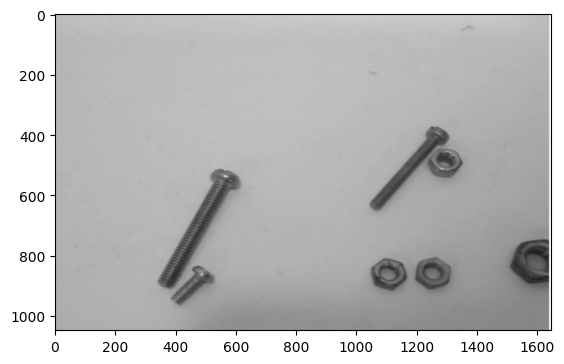

In [4]:
img = cv2.imread('src/bolts.png', 0)
print(img.shape)
plt.imshow(img, cmap='gray')

(524, 823)


(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 4.0000e+00, 7.0000e+00, 4.0000e+00, 7.0000e+00,
        9.0000e+00, 1.4000e+01, 1.0000e+01, 7.0000e+00, 2.0000e+00,
        1.1000e+01, 1.0000e+01, 7.0000e+00, 9.0000e+00, 1.8000e+01,
        2.0000e+01, 2.1000e+01, 2.0000e+01, 1.9000e+01, 1.8000e+01,
        2.6000e+01, 1.1000e+01, 1.7000e+01, 1.3000e+01, 3.2000e+01,
        4.2200e+02, 1.3000e+02, 1.1000e+02, 1.1500e+02, 1.2700e+02,
        1.4900e+02, 1.3600e+02, 1.6900e+02, 3.7400e+02, 2.0300e+02,
        2.2500e+02, 2.3400e+02, 2.4400e+02, 4.52

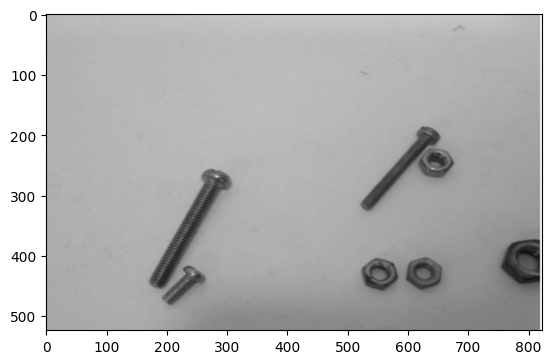

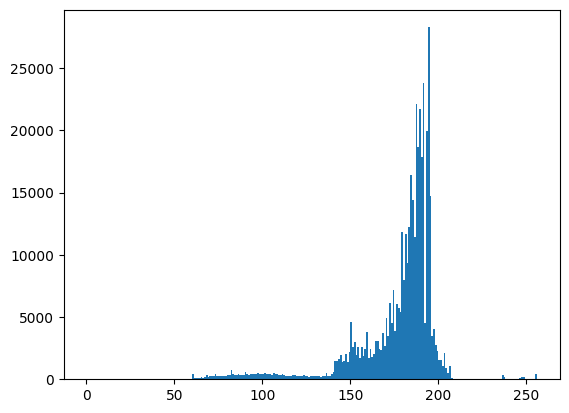

In [5]:
# resize
img_resize = cv2.resize(img, (0, 0), fx=0.5, fy=0.5)
print(img_resize.shape)
plt.imshow(img_resize, cmap='gray')
plt.figure()
plt.hist(img_resize.ravel(), 256, [0, 256])

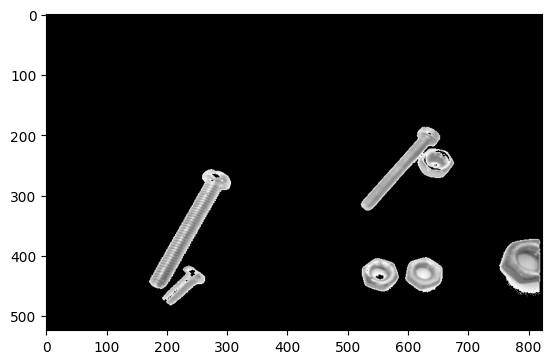

In [6]:
# threshold
_, img_tres = cv2.threshold(img_resize, 135, 255, cv2.THRESH_TOZERO_INV)
plt.imshow(img_tres, cmap='gray')

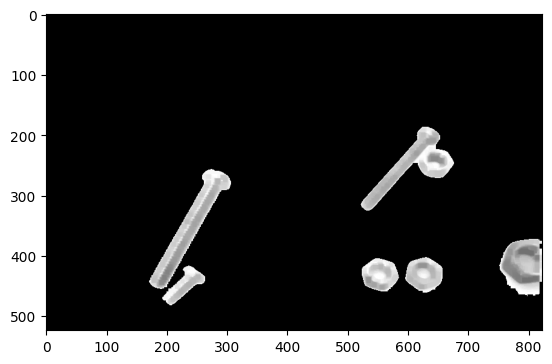

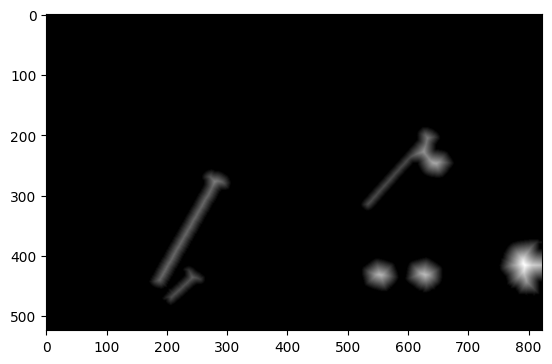

In [7]:
# closing
ksize = 7
kernel = np.ones((ksize, ksize), np.uint8)
closing = cv2.morphologyEx(img_tres,
                           cv2.MORPH_CLOSE,
                           kernel,
                           iterations=1)
plt.imshow(closing, cmap='gray')

# distance transform
dist = cv2.distanceTransform(closing, cv2.DIST_L2, 5)
cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
plt.figure()
plt.imshow(dist, cmap='gray')

6
area0: 1844.0
rect0: ((228.94863891601562, 454.32989501953125), (41.017112731933594, 73.29054260253906), 36.32682418823242)
area1: 2480.0
rect1: ((553.5499267578125, 431.85003662109375), (62.2968635559082, 51.861351013183594), 18.434947967529297)
area2: 2636.0
rect2: ((627.0203247070312, 430.87164306640625), (61.49500274658203, 54.636390686035156), 35.53767395019531)
area3: 5120.0
rect3: ((787.0, 420.0), (94.0, 70.0), 90.0)
area4: 6635.0
rect4: ((240.09466552734375, 359.3246765136719), (49.64440155029297, 220.571533203125), 26.837238311767578)
area5: 6098.0
rect5: ((605.624755859375, 273.0688781738281), (80.87538146972656, 175.21514892578125), 38.59846115112305)


/var/folders/xk/wz6j5qw9623dnjz28815491m0000gn/T/ipykernel_13954/2625680817.py:23: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


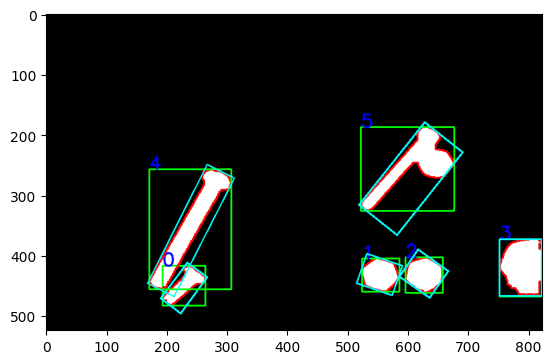

In [8]:
_,bw = cv2.threshold(closing, 0, 255, cv2.THRESH_BINARY)
mask = cv2.merge([bw, bw, bw])
plt.imshow(mask)
# draw contours
contours, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
for i in range(len(contours)):
    a = cv2.contourArea(contours[i])
    print(f'area{i}:',a)
    cv2.drawContours(mask, contours, i, (255, 0, 0), 2)

    x, y, w, h = cv2.boundingRect(contours[i])
    cv2.rectangle(mask, (x, y), (x+w, y+h), (0, 255, 0), 2)

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(mask, str(i), (x, y), font, 1, (0, 0, 255), 2, cv2.LINE_AA)

    # min area rect
    rect = cv2.minAreaRect(contours[i]) # (cen(x, y), (w, h), angle)
    # angle -> gripper head angle
    print(f'rect{i}:',rect)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(mask, [box], 0, (0, 255, 255), 2)

plt.imshow(mask)

In [9]:
screw_w = 40
nut_w = 60
err = 10

def classify(rect):
    w, h = rect[1]
    if w > screw_w and w < screw_w+err and h > screw_w :
        return 'screw'
    elif w > nut_w and w < nut_w+err:
        return 'nut'
    else:
        return 'unknown'

# classify
for i in range(len(contours)):
    rect = cv2.minAreaRect(contours[i])
    print(f'obj{i}:', classify(rect))

obj0: screw
obj1: nut
obj2: nut
obj3: unknown
obj4: screw
obj5: unknown


/var/folders/xk/wz6j5qw9623dnjz28815491m0000gn/T/ipykernel_13954/216812748.py:8: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


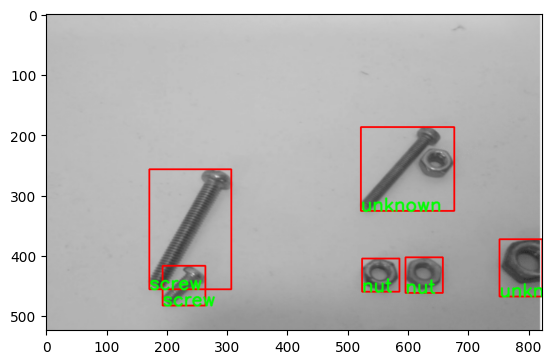

In [11]:
img2 = cv2.merge([img_resize, img_resize, img_resize])
for i in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[i])
    cv2.rectangle(img2, (x, y), (x+w, y+h), (255, 0, 0), 2)

    rect = cv2.minAreaRect(contours[i])
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.putText(img2, classify(rect), (x, y+h), font, 1, (0,255,0), 2, cv2.LINE_AA)

plt.imshow(img2, cmap='gray')

### To Do
0. looping until 0 unknown - oscillated tray
1. watershed lines - identify overlapped object
2. real-time detection - attach camera